In [1]:
import numpy as np
from astropy.table import Table
from synphot import SourceSpectrum, SpectralElement, units
from synphot.models import Empirical1D
import astropy.units as u
from scipy.special import erf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import root

In [2]:
def filters(fil):
    if fil == 'R':
        return 'Filters/Johnson-R.ecsv'
    elif fil == 'sdss-r':
        return 'Filters/sdss-r.ecsv'
    elif fil == 'cs_sdss-r':
        return 'Filters/cs_sdss.ecsv'
    elif fil=='Ha' or fil=='6563':
        return 'Filters/6563.ecsv'
    else:
        return str(fil)

In [3]:
def observatorysky(observatory):
    if observatory=='skinakas':
        sky = Table.read("Skies\skinakassky.ecsv", format='ascii.ecsv')
        skyss = SourceSpectrum(Empirical1D, points=sky['Wavelength (A)']*u.Angstrom, lookup_table=(sky['Sky (erg/s/cm^2/A/arcsec^2)']*units.FLAM))
        return skyss

In [4]:
def trans(fil):
    filfil = filters(fil)
    filtertrans = Table.read(filfil, format='ascii.ecsv')
    filterws = np.linspace(start=min(filtertrans['Wavelength (A)']), stop=max(filtertrans['Wavelength (A)']), num=1000)
    filterse = SpectralElement(Empirical1D, points=filtertrans['Wavelength (A)']*u.Angstrom, lookup_table=(filtertrans['Transmittance']))
    wavs = filtertrans['Wavelength (A)']
    return filterse, wavs

In [5]:
def flat(wavfl, fil):
    filterse, wavs = trans(fil)
    spec = np.add(np.multiply(0.0, np.array(wavs)), wavfl)
    wavs = wavs*u.Angstrom
    spec = spec*units.FLAM
    spectr = SourceSpectrum(Empirical1D, points=wavs, lookup_table=spec)
    through = filterse*spectr
    tot = through.integrate()
    return tot.decompose()

In [6]:
def flatext(wavfl, fil, extarea):
    filterse, wavs = trans(fil)
    spec = np.add(np.multiply(0.0, np.array(wavs)), wavfl)
    wavs = wavs*u.Angstrom
    spec = spec*units.FLAM
    spectr = SourceSpectrum(Empirical1D, points=wavs, lookup_table=spec)
    through = filterse*spectr
    through = through
    tot = through.integrate()
    tot = tot/extarea
    return tot.decompose()

In [7]:
def sky(observatory, fil):
    filterse, wavs = trans(fil)
    skyss = observatorysky(observatory)
    through = filterse*skyss
    tot = through.integrate()
    return tot.decompose()

In [8]:
def pointsn(sky, source, fwhm, siglim=5.0, qe=1.0):
    sig = fwhm/(2.0*np.sqrt(2.0*np.log(2.0)))
    fs = siglim*sig
    fsa = np.pi*((fs/2.0)**2.0)
    skyinstar = float(qe)*fsa*sky
    nsource = float(qe)*erf(siglim/np.sqrt(2.0))*source
    sn = nsource/np.sqrt(nsource+skyinstar)
    return sn.decompose()

In [9]:
def extsn(sky, source, platescale=(0.176991*u.arcsec), qe=1.0):
    sn = (qe*source)/np.sqrt((qe*source)+(qe*sky))
    sn = sn*((1.0/206264.806)*(u.rad/u.arcsec))*platescale
    return sn.decompose()

In [10]:
def flatsnprober(observatory, diam, fil, fwhm, fl, tlim, siglim=5.0, qe=1.0, plot=True):
    probes = flat(fl, fil)
    probeb = sky(observatory, fil)/((1.0*u.arcsec)**2.0)
    area = np.pi*((diam/2.0)**2.0)
    probes *= area
    probeb *= area
    time = np.linspace(1,tlim,int(tlim))
    sns = []
    for t in time:
        ts = t*u.s
        tests = (probes*ts).decompose()
        testb = (probeb*ts).decompose()
        prsn = pointsn(testb, tests, fwhm, siglim, qe)
        sns.append(prsn.value)
    if plot:
        plt.clf()
        plt.plot(time, sns)
        plt.title('Photometric SNR')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$t[s]$')
        plt.ylabel(r'$\frac{S}{N}\ \left[\sqrt{ph}\ \right]$')
        plt.show()
    snss = []
    if (1.0>=min(sns) and 1.0<=max(sns)):
        tosolve = np.subtract(sns, 1.0)
        solveinterp = interp1d(time, tosolve)
        roots = root(solveinterp, [time[0]])
        nr = np.rint(roots.x).astype(int)
        sn1 = nr[0]
        snss.append(sn1)
    else:
        snss.append(np.nan)
    if (2.0>=min(sns) and 2.0<=max(sns)):
        tosolve = np.subtract(sns, 2.0)
        solveinterp = interp1d(time, tosolve)
        roots = root(solveinterp, [time[0]])
        nr = np.rint(roots.x).astype(int)
        sn2 = nr[0]
        snss.append(sn2)
    else:
        snss.append(np.nan)
    if (3.0>=min(sns) and 3.0<=max(sns)):
        tosolve = np.subtract(sns, 3.0)
        solveinterp = interp1d(time, tosolve)
        roots = root(solveinterp, [time[0]])
        nr = np.rint(roots.x).astype(int)
        sn3 = nr[0]
        snss.append(sn3)
    else:
        snss.append(np.nan)
    return snss

In [11]:
def extsnprober(observatory, diam, fil, fl, extarea, tlim, platescale=(0.176991*u.arcsec), qe=1.0, plot=True):
    probes = flatext(fl, fil, extarea)
    probeb = sky(observatory, fil)/((1.0*u.arcsec)**2.0)
    area = np.pi*((diam/2.0)**2.0)
    probes *= area
    probeb *= area
    time = np.linspace(1,tlim,int(tlim))
    sns = []
    for t in time:
        ts = t*u.s
        tests = (probes*ts).decompose()
        testb = (probeb*ts).decompose()
        prsn = extsn(testb, tests, platescale, qe)
        sns.append(prsn.value)
    if plot:
        plt.clf()
        plt.plot(time, sns)
        plt.title('Mean Pixel SNR')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$t[s]$')
        plt.ylabel(r'$\frac{S}{N}\ \left[\sqrt{ph}\ \right]$')
        plt.show()
    snss = []
    if (1.0>=min(sns) and 1.0<=max(sns)):
        tosolve = np.subtract(sns, 1.0)
        solveinterp = interp1d(time, tosolve)
        roots = root(solveinterp, [time[0]])
        nr = np.rint(roots.x).astype(int)
        sn1 = nr[0]
        snss.append(sn1)
    else:
        snss.append(np.nan)
    if (2.0>=min(sns) and 2.0<=max(sns)):
        tosolve = np.subtract(sns, 2.0)
        solveinterp = interp1d(time, tosolve)
        roots = root(solveinterp, [time[0]])
        nr = np.rint(roots.x).astype(int)
        sn2 = nr[0]
        snss.append(sn2)
    else:
        snss.append(np.nan)
    if (3.0>=min(sns) and 3.0<=max(sns)):
        tosolve = np.subtract(sns, 3.0)
        solveinterp = interp1d(time, tosolve)
        roots = root(solveinterp, [time[0]])
        nr = np.rint(roots.x).astype(int)
        sn3 = nr[0]
        snss.append(sn3)
    else:
        snss.append(np.nan)
    return snss

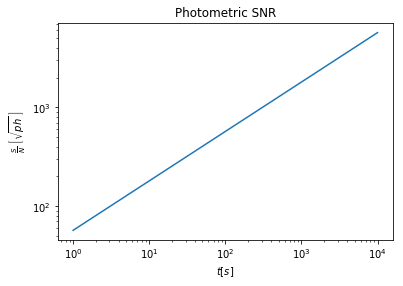

In [17]:
# tests = (flat(1.116172836850136e-15, 'sdss-r')*np.pi*(130.0/2.0*u.cm)*(130.0/2.0*u.cm)*(900*u.s)).decompose()
# testb = (sky('skinakas', 'sdss-r')*(130.0/2.0*u.cm)*np.pi*(130.0/2.0*u.cm)*(900*u.s)/((1.0*u.arcsec)**2.0)).decompose()
# snfin = pointsn(testb, tests, 1.0*u.arcsec, 15.0, 0.8)

# flatpointsn = flatsnprober('skinakas', 1.3*u.m, 'sdss-r', 1.0*u.arcsec, 1.116172836850136e-15, 10000.0, 15.0, 0.8, plot=True)
# dummy = flatsnprober('skinakas', 1.3*u.m, 'sdss-r', 1.0*u.arcsec, 1.116172836850136e-15, 100.0, 15.0, 0.8, plot=False)

In [13]:
# etests = (flatext(2.7652312061436463e-13, 'Ha', ((7.2*u.arcmin)*(5.4*u.arcmin)))*np.pi*((130.0/2.0)*u.cm)*((130.0/2.0)*u.cm)*(900*u.s)).decompose()
# etestb = (sky('skinakas', 'Ha')*(130.0/2.0*u.cm)*np.pi*(130.0/2.0*u.cm)*(900*u.s)/((1.0*u.arcsec)**2.0)).decompose()

# flatextsn = extsnprober('skinakas', 1.3*u.m, 'Ha', 2.7652312061436463e-13, ((7.2*u.arcmin)*(5.4*u.arcmin)), 10000.0, plot=False)
# dummy = extsnprober('skinakas', 1.3*u.m, 'Ha', 2.7652312061436463e-13, ((7.2*u.arcmin)*(5.4*u.arcmin)), 100.0, plot=False)

<Quantity 5066761.84098727 ph>